In [12]:
import tensorflow as tf
import numpy as np
#import mnist_handler
import matplotlib.pyplot as plt

"""load USPS"""
import h5py
hf =  h5py.File('UCI dataset/usps.h5', 'r')
train_dataset = hf.get('train')
x_train = train_dataset.get('data')[:]
y_train = train_dataset.get('target')[:]
test_dataset = hf.get('test')
x_test = test_dataset.get('data')[:]
y_test = test_dataset.get('target')[:]
print(x_train)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

INPUT_DIMENSION = 16*16
NUM_CLASSES = 10


border = 1291
x_train_init = x_train[:border]
y_train_init = y_train[:border]
x_train_seq = x_train[border:]
y_train_seq = y_train[border:]
print(x_train_seq.shape)

[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.1645 0.086  0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]
(2007, 256)
(7291,)
(2007,)
(6000, 256)


In [15]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
#matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

train_x =x_train
test_x = x_test
train_data = train_x.reshape(-1, 28,28, 1)
test_data = test_x.reshape(-1, 28,28, 1)
train_x = np.array(train_data)
test_x =  np.array(test_data)

from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_x,
                                                             train_x, 
                                                             test_size=0.2, 
                                                             random_state=13)

def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded


Using TensorFlow backend.


ValueError: cannot reshape array of size 1866496 into shape (28,28,1)

In [13]:
n_input_nodes = 256
n_hidden_nodes = 50  # used to be 256
n_output_nodes = 256

import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()

	"""BP autoencoder"""
	X = tf.placeholder(tf.float32, [None, n_input_nodes])
	Y = tf.placeholder(tf.float32, [None, n_output_nodes])

	encoding_layer = tf.layers.dense(inputs=X,units=n_hidden_nodes,activation=tf.math.sin)
	Y_hat = tf.layers.dense(inputs=encoding_layer,units=n_output_nodes,activation=None)

	loss = tf.losses.mean_squared_error(labels=Y,predictions=Y_hat)

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	t1 = time.time()
	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train):
			try:
				batch_x = x_train[i:i+BATCH_SIZE]
				batch_y = x_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train[i:]
				batch_y = x_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})
	t2 = time.time()
	time_sum+=(t2-t1)

	"""classification"""
	x_train_encoded = sess.run(encoding_layer, feed_dict={X: x_train})
	x_test_encoded = sess.run(encoding_layer, feed_dict={X: x_test})

	X = tf.placeholder(tf.float32, [None, n_hidden_nodes])
	Y = tf.placeholder(tf.int64, [None])
	Y_ = tf.one_hot(indices=Y, depth=10) # one_hot labels: [N,M]

	fc1 = tf.layers.dense(inputs=X,units=512,activation=tf.nn.relu)
	fc2 = tf.layers.dense(inputs=fc1,units=512,activation=tf.nn.relu)
	out = tf.layers.dense(inputs=fc2,units=10,activation=None)

	loss = tf.losses.softmax_cross_entropy(logits=out,onehot_labels=Y_)
	accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out,axis=1),tf.argmax(Y_,axis=1)),dtype=tf.float32))

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train_encoded):
			try:
				batch_x = x_train_encoded[i:i+BATCH_SIZE]
				batch_y = y_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train_encoded[i:]
				batch_y = y_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})

	"""evaluation"""
	avg_testing_acc = sess.run(accuracy, feed_dict={X: x_test_encoded, Y: y_test})
	print("Testing accuracy: ",avg_testing_acc)
	accuracy_sum+=avg_testing_acc

print("==========================================")
print("BP	 ===================================")
print("==========================================")
print("Average time: ", time_sum/10.0)
print("Average accuracy: ", accuracy_sum/10.0)
print("==========================================")

Testing accuracy:  0.94270056
Testing accuracy:  0.9431988
Testing accuracy:  0.94220227
Testing accuracy:  0.94469357


KeyboardInterrupt: 

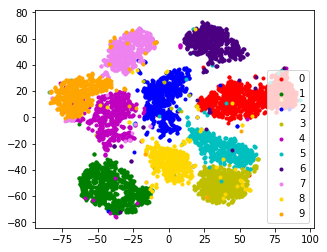

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(x_train_encoded)
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 4))
colors = 'r', 'g', 'b','y','m','c','indigo','violet','gold','orange'
for i, c, label in zip(target_ids,colors,  ['0','1','2','3','4','5','6','7','8','9']):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], c=c, label=label,marker = '.')
plt.legend()
plt.show()

In [2]:
from auto_elm import AUTO_ELM   # Our proposed algorithm
n_input_nodes = 256
n_hidden_nodes = 50  # used to be 256
n_output_nodes = 256

In [5]:
import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()
	# ===========================================
	# Instantiate os-elm
	# ===========================================
	auto_elm = AUTO_ELM(
		# the number of input nodes.
		n_input_nodes=n_input_nodes,
		# the number of hidden nodes.
		n_hidden_nodes=n_hidden_nodes,
		# the number of output nodes.
		n_output_nodes=n_output_nodes,
		# loss function.
		# the default value is 'mean_squared_error'.
		# for the other functions, we support
		# 'mean_absolute_error', 'categorical_crossentropy', and 'binary_crossentropy'.
		c_value = 2.0**(2),
		loss='mean_squared_error',
		# activation function applied to the hidden nodes.
		# the default value is 'sigmoid'.
		# for the other functions, we support 'linear' and 'tanh'.
		# NOTE: OS-ELM can apply an activation function only to the hidden nodes.
		activation='sin',
	)
	# ===========================================
	# Training
	# ===========================================
	# the initial training phase
	t1 = time.time()
	auto_elm.init_train(x_train_init, x_train_init)
	t2 = time.time()
	time_sum+=(t2-t1)

	# the sequential training phase
	batch_size = 1000

	t1 = time.time()
	for epoch in range(50):
		for i in range(0, len(x_train_seq), batch_size):
			x_batch = x_train_seq[i:i+batch_size]
			if len(x_batch) != batch_size:
				break
			auto_elm.seq_train(x_batch, x_batch)
	t2 = time.time()
	time_sum+=(t2-t1)

In [6]:
time_sum = time_sum/10

In [7]:
x_train_encoded = auto_elm.encoding(x_train)
x_test_encoded = auto_elm.encoding(x_test)
x_train_encoded.shape


(7291, 50)

In [9]:
#palette = np.array(sns.color_palette("hls", num_classes))
palette=sns.color_palette("hls", 10),
#sc = ax.scatter(x_train_encoded[:,0], x_train_encoded[:,1], lw=0, s=40, c=palette[colors.astype(np.int)]

SyntaxError: unexpected EOF while parsing (<ipython-input-9-69bc318221c5>, line 3)

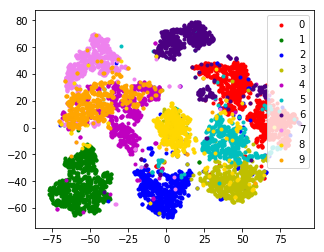

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(x_train_encoded)
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 4))
colors = 'r', 'g', 'b','y','m','c','indigo','violet','gold','orange'
for i, c, label in zip(target_ids,colors,  ['0','1','2','3','4','5','6','7','8','9']):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], c=c, label=label,marker = '.')
plt.legend()
plt.show()

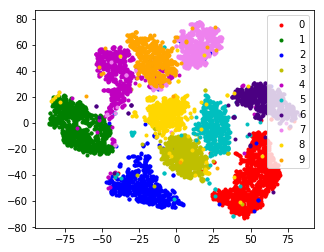

In [18]:
X_embedded = TSNE(n_components=2).fit_transform(x_train)
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 4))
colors = 'r', 'g', 'b','y','m','c','indigo','violet','gold','orange'
for i, c, label in zip(target_ids,colors,  ['0','1','2','3','4','5','6','7','8','9']):
    plt.scatter(X_embedded[y_train == i, 0], X_embedded[y_train == i, 1], c=c, label=label,marker = '.')
plt.legend()
plt.show()

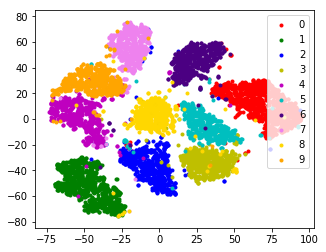

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x_train)
X_2d = tsne.fit_transform(principalComponents)
target_ids = range(10)

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 4))
colors = 'r', 'g', 'b','y','m','c','indigo','violet','gold','orange'
for i, c, label in zip(target_ids,colors,  ['0','1','2','3','4','5','6','7','8','9']):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], c=c, label=label,marker = '.')
plt.legend()
plt.show()

In [19]:
X_2d.shape

(7291, 2)

In [6]:

border = 1291
x_train_init = x_train_encoded[:border]
y_train_init = y_train[:border]
x_train_seq = x_train_encoded[border:]
y_train_seq = y_train[border:]
INPUT_DIMENSION = 50
NUM_CLASSES = 10

In [7]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(-1))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)


np.savetxt("x_train.csv", x_train, delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("x_test.csv", x_test, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

In [8]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

In [9]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

# Initial Training

In [10]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init




In [11]:
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [13]:
"""Initial training"""
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.09603342
Initial train training accuracy:  0.1611576
Initial train testing loss:  0.09730178
Initial train testing accuracy:  0.16542102


In [14]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [15]:
"""Initial training"""
sess.run(E_2_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.09612303
Initial train training accuracy:  0.15827733
Initial train testing loss:  0.09738838
Initial train testing accuracy:  0.16591929


In [16]:
"""Evaluate initial-training graph"""
logits_init =  subnet_output(alpha_1, beta_1, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [17]:
"""Initial training"""
sess.run(E_1_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.09621956
Initial train training accuracy:  0.1577287
Initial train testing loss:  0.09746604
Initial train testing accuracy:  0.16292974


# Sequential Training

In [18]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq





In [19]:
logits_seq =  subnet_output(alpha_1, beta_1, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [20]:
"""Initialize variables"""
#init = tf.global_variables_initializer()
#sess.run(init)

"""Sequential training"""
batch_size = 1000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(20):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_1_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.095082, train_accuracy: 0.172953
test_loss: 0.096152, test_accuracy: 0.176881
train_loss: 0.093842, train_accuracy: 0.189000
test_loss: 0.094825, test_accuracy: 0.197309
train_loss: 0.092936, train_accuracy: 0.196544
test_loss: 0.093820, test_accuracy: 0.201794
train_loss: 0.092358, train_accuracy: 0.199287
test_loss: 0.093164, test_accuracy: 0.206278
train_loss: 0.092005, train_accuracy: 0.203676
test_loss: 0.092753, test_accuracy: 0.211261
train_loss: 0.091787, train_accuracy: 0.205459
test_loss: 0.092496, test_accuracy: 0.211261
train_loss: 0.091651, train_accuracy: 0.205596
test_loss: 0.092329, test_accuracy: 0.211759
train_loss: 0.091562, train_accuracy: 0.206419
test_loss: 0.092218, test_accuracy: 0.210762
train_loss: 0.091502, train_accuracy: 0.206419
test_loss: 0.092141, test_accuracy: 0.211759
train_loss: 0.091460, train_accuracy: 0.206145
test_loss: 0.092086, test_accuracy: 0.214250
train_loss: 0.091430, train_accuracy: 0.206830
test_loss: 0.092046, test_accurac

'Sequential training evaluation'

In [21]:
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [22]:
"""Initialize variables"""
#init = tf.global_variables_initializer()
#sess.run(init)

"""Sequential training"""
batch_size = 2000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(15):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    t1 = time.time()
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_2_seq, feed_dict={X_: x_batch, Y: y_batch})
    t2 = time.time()
    time_sum+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
time_sum

train_loss: 0.091181, train_accuracy: 0.209985
test_loss: 0.091764, test_accuracy: 0.212257
train_loss: 0.091175, train_accuracy: 0.210396
test_loss: 0.091758, test_accuracy: 0.212257
train_loss: 0.091170, train_accuracy: 0.211219
test_loss: 0.091752, test_accuracy: 0.211759
train_loss: 0.091166, train_accuracy: 0.211219
test_loss: 0.091747, test_accuracy: 0.212257
train_loss: 0.091162, train_accuracy: 0.211631
test_loss: 0.091744, test_accuracy: 0.211759
train_loss: 0.091159, train_accuracy: 0.211494
test_loss: 0.091740, test_accuracy: 0.212257
train_loss: 0.091156, train_accuracy: 0.211494
test_loss: 0.091737, test_accuracy: 0.212257
train_loss: 0.091154, train_accuracy: 0.211356
test_loss: 0.091735, test_accuracy: 0.213254
train_loss: 0.091151, train_accuracy: 0.211356
test_loss: 0.091732, test_accuracy: 0.213752
train_loss: 0.091149, train_accuracy: 0.211356
test_loss: 0.091730, test_accuracy: 0.213752
train_loss: 0.091146, train_accuracy: 0.211356
test_loss: 0.091728, test_accurac

0.8790624856948852

In [23]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [24]:
"""Sequential training"""
batch_size = 2000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(20):
    t1 = time.time()
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y: y_batch})
    t2 = time.time()
    time_sum+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)

train_loss: 0.091135, train_accuracy: 0.211356
test_loss: 0.091718, test_accuracy: 0.214250
train_loss: 0.091133, train_accuracy: 0.211219
test_loss: 0.091716, test_accuracy: 0.214748
train_loss: 0.091131, train_accuracy: 0.211356
test_loss: 0.091715, test_accuracy: 0.214250
train_loss: 0.091129, train_accuracy: 0.211494
test_loss: 0.091713, test_accuracy: 0.214250
train_loss: 0.091127, train_accuracy: 0.211631
test_loss: 0.091712, test_accuracy: 0.214250
train_loss: 0.091125, train_accuracy: 0.211631
test_loss: 0.091710, test_accuracy: 0.214250
train_loss: 0.091122, train_accuracy: 0.211768
test_loss: 0.091709, test_accuracy: 0.213752
train_loss: 0.091120, train_accuracy: 0.211768
test_loss: 0.091707, test_accuracy: 0.214250
train_loss: 0.091118, train_accuracy: 0.211494
test_loss: 0.091705, test_accuracy: 0.213752
train_loss: 0.091116, train_accuracy: 0.211768
test_loss: 0.091704, test_accuracy: 0.213254
train_loss: 0.091114, train_accuracy: 0.211768
test_loss: 0.091702, test_accurac

'Sequential training evaluation'

In [25]:
logits_ = subnet_output(alpha_1, beta_1, X_) 
logits__ = sess.run(logits_, feed_dict={X_: [x_test_encoded[222]]})
print(logits__)
print(np.argmax(logits__))
print(y_test[222])
#plt.imshow(np.reshape(x,(10,10)))

[[ 0.16582295 -0.03818133  0.03261058  0.07620622 -0.0817162   0.07382142
  -0.01251365 -0.0214326   0.11159307  0.01529774]]
0
8


ValueError: cannot reshape array of size 5 into shape (16,16)

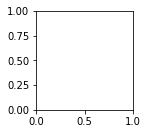

In [26]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 16)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 16)
visualize_beta(beta_2)

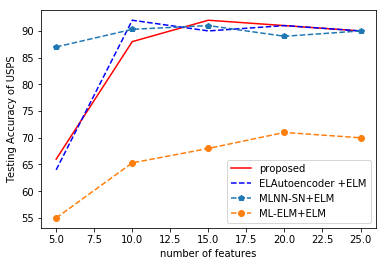

In [2]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
x = [5,10,15,20,25]
y1 = [66,88,92,91,90]
y2 = [64,92,90,91,90]
y3 = [87,90.3,91,89,90]
y4 = [55,65.3,68,71,70]

plt.plot(x,y1,'-r')
plt.plot(x,y2,'--b')
plt.plot(x,y3,'--p')
plt.plot(x,y4,'--o')
plt.ylabel('Testing Accuracy of USPS')
plt.xlabel('number of features')
plt.legend(['proposed', 'ELAutoencoder +ELM','MLNN-SN+ELM','ML-ELM+ELM'], loc='lower right')

In [2]:
plt.plot(x,y1,'--r')
plt.plot(x,y2,'--b')
plt.ylabel('Training Accuracy of USPS')
plt.xlabel('number of features')
plt.legend(['proposed', 'autoencoder +ELM'], loc='lower right')

NameError: name 'plt' is not defined

In [ ]:
sess.run(tf.math.sin(tf.constant([0.9])))